# Сборный проект №2

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:
1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


# Подготовьте данные

## 1.1 Откройте файлы и изучите их. Путь к файлам:



In [197]:
# импорт необходимых для проекта библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor


In [198]:
# импорт файлов из предполагаемых директорий
pth1 = 'datasets/gold_industry_train.csv'
pth2 = 'datasets/gold_industry_test.csv'
pth3 = 'datasets/gold_industry_full.csv'
pth4= '/content/drive/MyDrive/Colab Notebooks/datasets/gold_industry_train.csv'
pth5 = '/content/drive/MyDrive/Colab Notebooks/datasets/gold_industry_test.csv'
pth6 = '/content/drive/MyDrive/Colab Notebooks/datasets/gold_industry_full.csv'

if os.path.exists(pth1):
    df_train = pd.read_csv(pth1)
    df_test = pd.read_csv(pth2)
    df_full = pd.read_csv(pth3)
elif os.path.exists(pth4):
    df_train = pd.read_csv(pth4)
    df_test = pd.read_csv(pth5)
    df_full = pd.read_csv(pth6)

else:
    print("Проверьте правильность пути к датасету")

# краткий обзор датасета
print('В Обучающей выборке:', df_train.shape[0], 'строк и', df_train.shape[1], 'столбцов.')
display(df_train.head(1))
print()
print('В Тестовой выборке:', df_test.shape[0], 'строк и', df_test.shape[1], 'столбцов.')
print()
display(df_test.head(1))
print()
print('В Исходной выборке:', df_full.shape[0], 'строк и', df_full.shape[1], 'столбцов.')
display(df_full.head(1))



## 1.2 Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [199]:
# Напишем формулу эффективности обогащения
С = df_train['rougher.output.concentrate_au'] # доля золота в Концентрате ПОСЛЕ флотации\очистки
F = df_train['rougher.input.feed_au'] # доля золота в сырье\конц ДО флотции\очистки  
T = df_train['rougher.output.tail_au'] # доля золота в сырье\конц ДО флотции\очистки 
RECOVERY = ((С * ( F - T )) * 100) / (F * (С - T))
print(mean_squared_error(df_train['rougher.output.recovery'], RECOVERY))

> **MAE** стремится к нулю, а значит эффективность обогащения скорее всего посчитана верно.

## 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся? 

In [200]:
display(set(df_train.columns) - set(df_test.columns))

В тестовой выборке **нет параметров продукта**, получившегося в результате каждого из этапов очистки, а также рассчетные значения содержания sulfate. Эти даные не релевантны для поставленной для модели задачи т.к. являются уже **итогом** обработки каждого из этапов. Также в тестовую выборку не вошли целевые признаки  'final.output.recovery' и 'rougher.output.recovery'.

Для построения модели потребуется удалить эти признаки из тренировочной выборки.


## 1.4. Проведите предобработку данных.

In [201]:
# Удалим из df_train ненужные признаки
df_train = df_train.drop((set(df_train.columns) - set(df_test.columns)), axis = 1)


In [202]:
# Вернем целевые признаки, которых не было в тестовой и выше были удалены со всеми
df_train.index, df_full.index = df_train['date'], df_full['date']
df_train['rougher.output.recovery'] = df_full['rougher.output.recovery'][df_train.index]
df_train['final.output.recovery'] = df_full['final.output.recovery'][df_train.index]

df_train = df_train.reset_index(drop=True)
df_full = df_full.reset_index(drop=True)



In [203]:
# Есть ли столбцы с пропущенныеми зачения?
df_train.columns[df_train.isna().sum() > 0]

# Заместим пропущенные значения рядом стоящим т.к. по условию соседние по времени параметры часто похожи.
df_train = df_train.fillna(method='ffill')

# Есть ли дубликаты?
print('Найденно дубликатов в Тренировочной выборке:', df_train.duplicated().sum())
print('Пропущенных значений в Тренировочной выборке:', df_train.isna().sum().sum())
print('В Тренировочной выборке:', df_train.shape[1],'признаков. А в Тестовой выборке:', df_test.shape[1])

## Сразу откорректируем Тестовую выборку

In [204]:
print('В Тестовой выборке:', df_test.shape[0], 'строк и', df_test.shape[1], 'столбцов.')
print('Пропущенных значений в Тестовой выборке:', df_test.isna().sum().sum())
# Замещаем пропущенные значения согласно условию, что близжайшие индексы похожи друг на друга
df_test = df_test.fillna(method='ffill')


# Добавим целевые признаки воспользовавшись полным списком индексов из df_full
df_test.index, df_full.index = df_test['date'], df_full['date']
df_test['rougher.output.recovery'] = df_full['rougher.output.recovery'][df_test.index]
df_test['final.output.recovery'] = df_full['final.output.recovery'][df_test.index]
df_test = df_test.reset_index(drop=True)
df_full = df_full.reset_index(drop=True)
# Удаляем столбец, который также не пригодится для обучения модели
df_test = df_test.drop('date', axis = 1)

print('Пропущенных значений в Тестовой выборке после замещения:', df_test.isna().sum().sum())
print('В Тестовой выборке:', df_test.shape[0], 'строк и', df_test.shape[1], 'столбцов.')
display(df_train.head(1))



**По итогам первого этапа:**
* Убедились, что эффективность обогащения в данных посчитана верно, посчитав самостоятельно MAE.
* Выяснили особенности признаков, оставленных в тестовой выборке, а также недостаток в ней целевых признаков, которые пришлось добавить
* Обьединили тестовую и тренировочную выборку о набору признаков, что поможет в обучении модели.
* Убедились, что нет выборках нет дубликатов, а пропущенные значения заместили согласуясь с условиями задачи, используя данные соседних строк.

# 2. Проанализируйте данные


## 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.
Какие особенности имеют распределения? Опишите выводы.

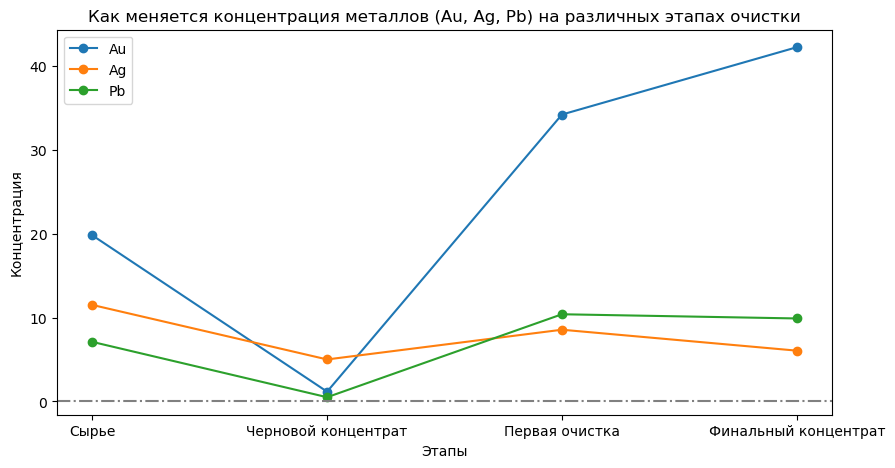

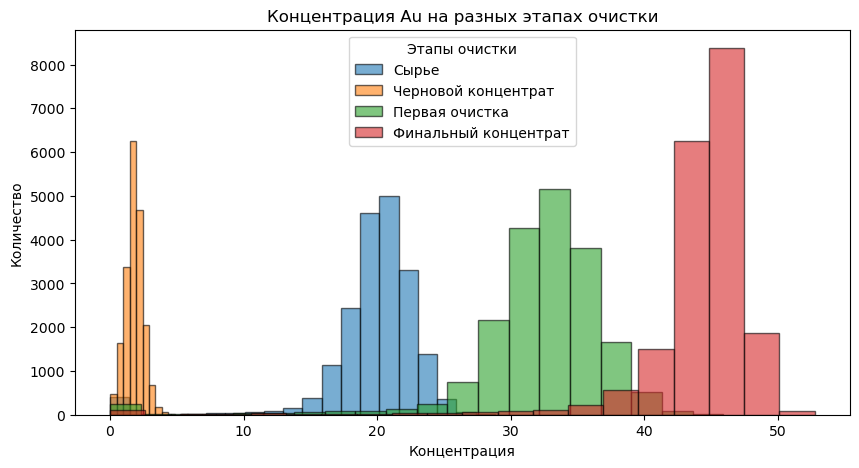

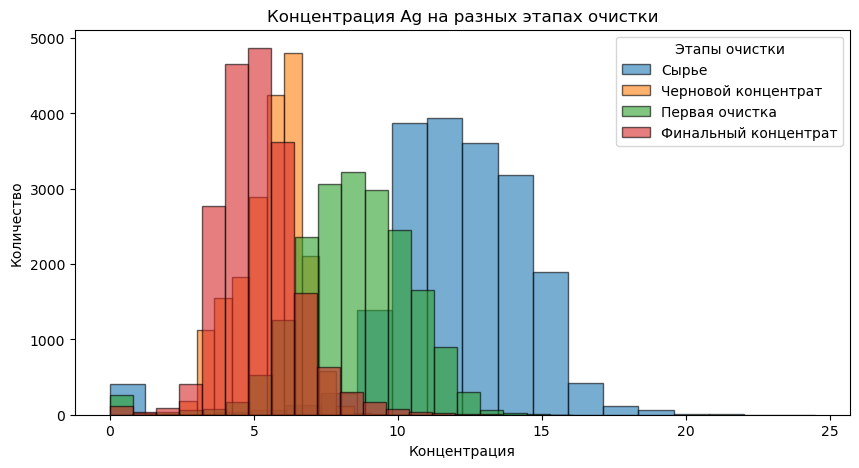

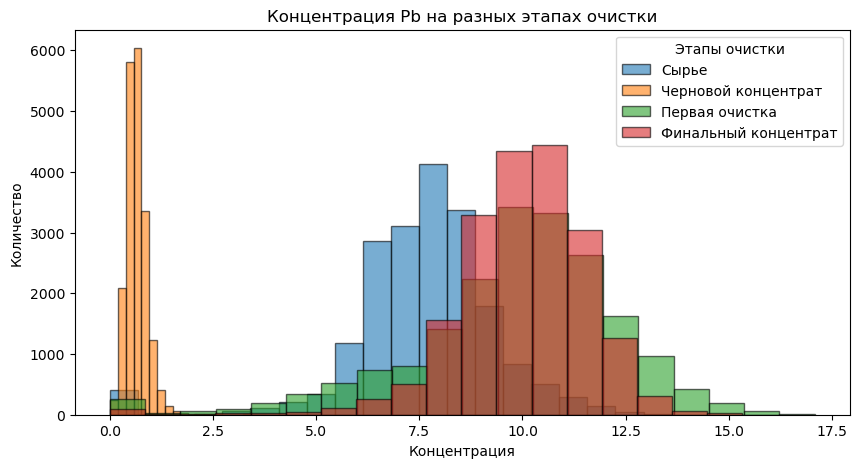

In [205]:
au = pd.DataFrame({'Сырье': df_full['rougher.output.concentrate_au'],
      'Черновой концентрат': df_full['rougher.output.tail_au'],
      'Первая очистка': df_full['primary_cleaner.output.concentrate_au'],
      'Финальный концентрат': df_full['final.output.concentrate_au']})
ag = pd.DataFrame({'Сырье': df_full['rougher.output.concentrate_ag'],
      'Черновой концентрат': df_full['rougher.output.tail_ag'],
      'Первая очистка': df_full['primary_cleaner.output.concentrate_ag'],
      'Финальный концентрат': df_full['final.output.concentrate_ag']})
pb = pd.DataFrame({'Сырье': df_full['rougher.output.concentrate_pb'],
      'Черновой концентрат': df_full['rougher.output.tail_pb'],
      'Первая очистка': df_full['primary_cleaner.output.concentrate_pb'],
      'Финальный концентрат': df_full['final.output.concentrate_pb']})

plt.figure(figsize=(10, 5))
plt.plot(au.columns, au.iloc[0], label='Au', marker='o')
plt.plot(ag.columns, ag.iloc[0], label='Ag', marker='o')
plt.plot(pb.columns, pb.iloc[0], label='Pb', marker='o')
plt.axhline(y=0, linestyle='-.', color='gray')
plt.legend()

plt.xlabel('Этапы')
plt.ylabel('Концентрация')
plt.title('Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки')

plt.show()


metals = [au, ag, pb]
metal_names = ['Au', 'Ag', 'Pb']
stage_names = ['Сырье', 'Черновой концентрат', 'Первая очистка', 'Финальный концентрат']

for i in range(len(metals)):
    metal_cols = metals[i].columns.tolist() # список столбцов текущего датафрейма metals[i]
    plt.figure(figsize=(10, 5))
    for j in range(len(metal_cols)):
        plt.hist(metals[i][metal_cols[j]], bins=20, alpha=0.6, edgecolor='black', label=metal_cols[j])

    plt.xlabel('Концентрация')
    plt.ylabel('Количество')
    plt.title(f'Концентрация {metal_names[i]} на разных этапах очистки')
    plt.legend(title='Этапы очистки', loc='best')
    plt.show()


>Концентрация золотая растет на каждом этапе очистки. И в итоге более чем в два раза превышает исходную. 

>В черновом концентрате среди всех металлов преобладает Серебро, что заметно на последующих этапах очистки: свинца становится больше, чем серебра. Это может говорить о несовершенстве методов очистки, либо об подмечает его особенности.

>Также обращают на себя внимание **аномалии** в виде видимого кол-ва концентраций близких нулю на всех этапах среди всех металлов.

In [206]:
print("Количество строк в df_full до удаления аномалий:", len(df_full))
print("Количество строк в df_train до удаления аномалий:", len(df_train))
columns = [
    'rougher.output.concentrate_au',
    'rougher.output.tail_au',
    'primary_cleaner.output.concentrate_au',
    'final.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.tail_ag',
    'primary_cleaner.output.concentrate_ag',
    'final.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.tail_pb',
    'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_pb',
]

df_full[columns] = df_full[columns].replace(0, np.nan)
df_full.dropna(subset=columns, inplace=True)

df_train = df_train[df_train['date'].isin(df_full['date'])]

print("Количество строк в df_full после удаления аномалий:", len(df_full))
print("Количество строк в df_train после удаления аномалий:", len(df_train))

In [207]:
#Теперь можно удалить ненужный столбец
df_train = df_train.drop('date', axis = 1)

## 2.2.  Сравните распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

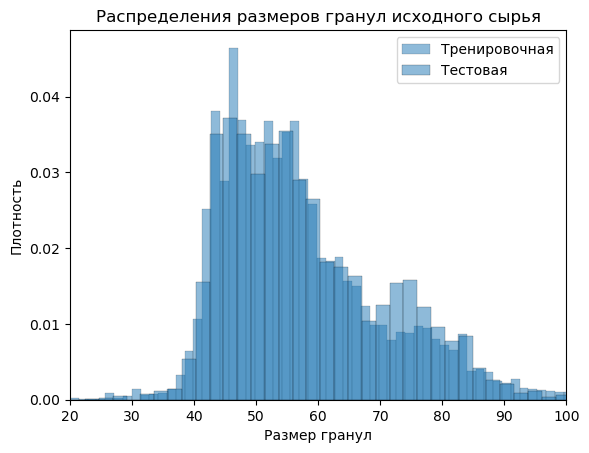

In [208]:
fig, ax = plt.subplots(1, 1)
sns.histplot(df_train, x='rougher.input.feed_size', stat='density', alpha=0.5, label='Тренировочная', ax=ax)
sns.histplot(df_test, x='rougher.input.feed_size', stat='density', alpha=0.5, label='Тестовая', ax=ax)

ax.set_xlim([20, 100])
ax.set_xlabel('Размер гранул')
ax.set_ylabel('Плотность')
ax.set_title('Распределения размеров гранул исходного сырья')
plt.legend()

plt.show()






>Как видно из графика, в целом, распределения гранул в выборках совпадает.

## 2.3. Исследуйте суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

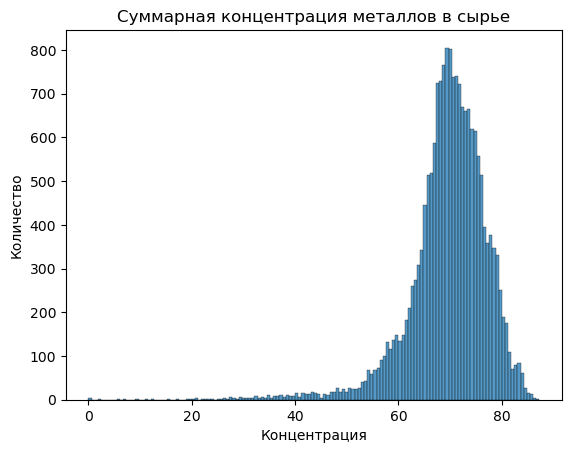

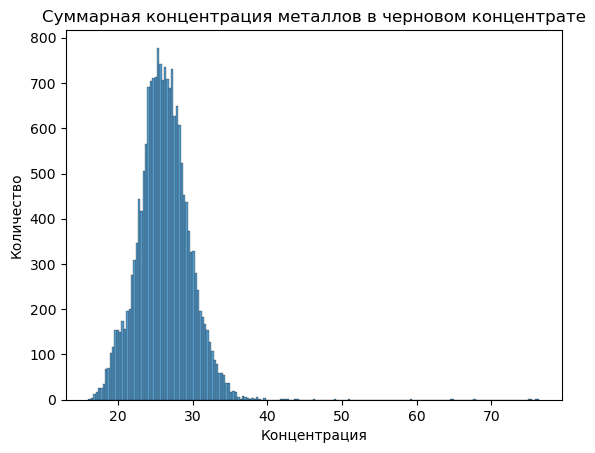

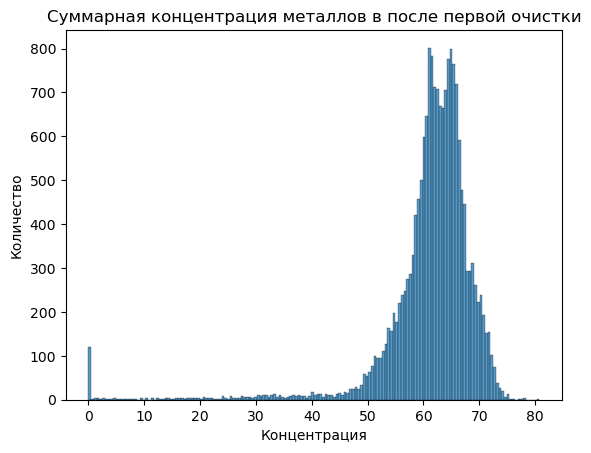

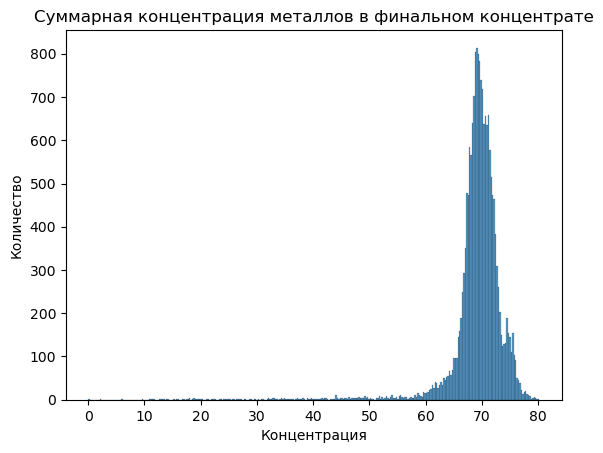

In [209]:
sol = pd.DataFrame({'Сырье': df_full['rougher.output.concentrate_sol'],
      'Черновой концентрат': df_full['rougher.output.tail_sol'],
      'Первая очистка': df_full['primary_cleaner.output.concentrate_sol'],
      'Финальный концентрат': df_full['final.output.concentrate_sol']})
###
roughe_stage = pd.DataFrame({'Золото': df_full['rougher.output.concentrate_au'],
      'Серебро': df_full['rougher.output.concentrate_ag'],
      'Свинец': df_full['rougher.output.concentrate_pb'],
      'sol': df_full['rougher.output.concentrate_sol']})

tail_stage = pd.DataFrame({'Золото': df_full['rougher.output.tail_au'],
      'Серебро': df_full['rougher.output.tail_ag'],
      'Свинец': df_full['rougher.output.tail_pb'],
      'sol': df_full['rougher.output.tail_sol']})

primary_cleaner_stage = pd.DataFrame({'Золото': df_full['primary_cleaner.output.concentrate_au'],
      'Серебро': df_full['primary_cleaner.output.concentrate_ag'],
      'Свинец': df_full['primary_cleaner.output.concentrate_pb'],
      'sol': df_full['primary_cleaner.output.concentrate_sol']})

final_stage = pd.DataFrame({'Золото': df_full['final.output.concentrate_au'],
      'Серебро': df_full['final.output.concentrate_ag'],
      'Свинец': df_full['final.output.concentrate_pb'],
      'sol': df_full['final.output.concentrate_sol']})


stages = [roughe_stage, tail_stage, primary_cleaner_stage, final_stage]
stage_name = ['сырье', 'черновом концентрате', 'после первой очистки', 'финальном концентрате']
for i in range(len(stages)):
    total_concentration = stages[i]['Золото'] + stages[i]['Серебро'] + stages[i]['Свинец'] + stages[i]['sol']
    sns.histplot(total_concentration)
    plt.title(f'Суммарная концентрация металлов в {stage_name[i]}')
    plt.xlabel('Концентрация')
    plt.ylabel('Количество')
    plt.show()



## Выводы:
* Концентрация золота и свинца на каждой стадии очистки повышается, а концентрация серебра падает.
* Было определено содержание аномалий в качестве видимого кол-ва концентраций близких нулю на всех этапах обработки среди всех металлов.
* Распределения размеров гранул сырья на обучающей и тестовой выборках выглядят одинаково.
* Распределеине сумарной концентрации сужается по мере прохождения этапов обработки, концентрация растет.



# 3. Постройте модель

## 3.1. Напишите функцию для вычисления итоговой sMAPE.

In [210]:
def smape(target, prediction):
    result = np.sum(abs(target - prediction) / ((abs(target) + abs(prediction)) / 2)) * 100/len(target)
    return result

def smape_end(rougher, final):
    return  0.25*rougher + 0.75*final

## 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.







In [211]:

# определяем обучающие и целевые признаки в тренировочной выборке
target_train_rougher = df_train['rougher.output.recovery']
target_train_final = df_train['final.output.recovery']
features_train = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

# Определяем обучающие и целевые признаки в тестовой выборке
target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']
features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [212]:
# Масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
#Проверяем
features_test.shape, features_train.shape

In [213]:
# Сделаем константную модель sMAPE для проверок
predict_rougher = target_train_rougher.median()
predict_final = target_train_final.median()

smape_rougher = smape(target_test_rougher, predict_rougher)
smape_final = smape(target_test_final, predict_final)
SMAPE = smape_end(smape_rougher, smape_final)

print('Итоговая SMAPE-константа:', SMAPE)

### RandomForestRegressor Тренировочная выборка

In [214]:
score = make_scorer(smape, greater_is_better=False) 

model_rfr_r = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": range(50, 201, 25),
    "max_depth": [None] + [i for i in range(2, 7)],
}
grid_search = GridSearchCV(
    model_rfr_r, 
    param_grid, 
    scoring=score, 
    cv=5, n_jobs=-1)
grid_search.fit(features_train, target_train_rougher)
best_r_score = grid_search.best_score_ * -1

print('Лучшие гиперпараметры:', grid_search.best_params_)
print('Лучшее значение тренировочной SMAPE сырья:', best_r_score)



In [215]:
model_rfr_f = RandomForestRegressor(random_state=42)


param_grid = {
    "n_estimators": range(50, 201, 25),
    "max_depth": [None] + [i for i in range(2, 7)],
    
}
grid_search = GridSearchCV(
    model_rfr_f, 
    param_grid,
    scoring=score, 
    cv=5, n_jobs=-1)
grid_search.fit(features_train, target_train_final)
best_f_score = grid_search.best_score_ * -1

print('Лучшие гиперпараметры:', grid_search.best_params_)
print('Лучшее значение тренировочной SMAPE финальн конц.:', best_f_score)

In [216]:
print('Итоговое SMAPE тренировочной модели RandomForestRegressor:', smape_end(best_r_score,best_f_score))

### DecisionTreeRegressor тренировочная выборка 

In [217]:
model_dtr_r = DecisionTreeRegressor(random_state=42)

param_grid = {
    "max_depth": [None] + [i for i in range(2, 7)],
    "min_samples_split": range(2, 21, 5),
    "min_samples_leaf": range(1, 51, 10)
}

grid_search = GridSearchCV(model_dtr_r, 
                  param_grid, 
                  scoring=score, 
                  cv=5,
                  n_jobs=-1)
grid_search.fit(features_train, target_train_rougher)
best_r_score = grid_search.best_score_ * -1

print('Лучшие гиперпараметры:', grid_search.best_params_)
print('Лучшее значение тренировочной SMAPE сырья:', best_r_score)

In [218]:
model_dtr_f = DecisionTreeRegressor(random_state=42)

param_grid = {
    "max_depth": [None] + [i for i in range(2, 7)],
    "min_samples_split": range(2, 21, 5),
    "min_samples_leaf": range(1, 51, 10)
}

grid_search = GridSearchCV(model_dtr_f, 
                  param_grid, 
                  scoring=score, 
                  cv=5,
                  n_jobs=-1)
grid_search.fit(features_train, target_train_final)
best_f_score = grid_search.best_score_ * -1

print('Лучшие гиперпараметры:', grid_search.best_params_)
print('Лучшее значение тренировочной SMAPE финальн конц.:', best_f_score)

In [219]:
print('Итоговое SMAPE тренировочной модели DecisionTreeRegressor:', smape_end(best_r_score,best_f_score))

### LinearRegression тренировочная выборка

In [220]:
model_lr_r = LinearRegression()

lr_scores = cross_val_score(
    model_lr_r, 
    features_train, 
    target_train_rougher, 
    scoring=score, cv=5)
lr_scores = lr_scores * -1
mean_r_score = lr_scores.mean()

print('Все оценки:', lr_scores * -1 )
print('Среднее:', mean_r_score)

In [ ]:
model_lr_f = LinearRegression()

lr_scores = cross_val_score(
    model_lr_f, 
    features_train, 
    target_train_final, 
    scoring=score, cv=5)
lr_scores = lr_scores * -1
mean_f_score = lr_scores.mean()

print('Все оценки:', lr_scores * -1 )
print('Средняя:', mean_f_score)

In [ ]:
print('Итоговое SMAPE тренировочной модели LinearRegression:', smape_end(mean_r_score,mean_f_score))

Лучше всего с задаче справилась модель Случайного леса с показателем итоговой SMAPE: 6.3 и параметрами {'max_depth': 6, 'n_estimators': 125}

### Проверяем лучшую модель на тестовой выборке

In [227]:
model_r = RandomForestRegressor(random_state=42, n_estimators=125, max_depth=6)

model_r.fit(features_train, target_train_rougher)

prediction = model_r.predict(features_test)

best_score_r = smape(target_test_rougher, prediction)
print(f'Лучшее значение SMAPE для сырья: {best_score_r}')

In [228]:
model_f = RandomForestRegressor(random_state=42, n_estimators=125, max_depth=6)

model_f.fit(features_train, target_train_final)

prediction = model_f.predict(features_test)

best_score_f = smape(target_test_final, prediction)
print(f'Лучшее значение SMAPE для финального концентрата: {best_score_f}')

In [229]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train_rougher)
dummy_pred_r= dummy.predict(features_test)

dummy.fit(features_train, target_train_final)
dummy_pred_f= dummy.predict(features_test)

dummy_score_r = smape(target_test_rougher, dummy_pred_r)
dummy_score_f = smape(target_test_final, dummy_pred_f)


print('Итоговое SMAPE тестовой модели DummyRegressor ', smape_end(dummy_score_r, dummy_score_f))

print('Итоговое SMAPE тестовой модели RandomForestRegressor:', smape_end(best_score_r,best_score_f))


> Подобранная нами модель показывает результаты SMAPE лучше константной модели, а значит модель приносит результат.

# Вывод

1. Была произведена предобработка данных для обучения;
2. Проведен исследовательский анализ данных, выявлены и устранены аномалии;
3. Построили и обучили три модели, лучшей из которых оказалась модель Случайного леса..

Лучше всего прошла проверку кросс-валидацией модель Случайного леса. Единственная, кто показал себя лучше чем другие модели в сравнении с константной SMAPE
Итоговое SMAPE тестовой модели RandomForestRegressor: 6.2877020697306705